In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from PIL import Image, UnidentifiedImageError
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Copy dataset from Google Drive to Colab local storage for faster access
!cp -r "/content/drive/MyDrive/dataset" "/content/dataset"

# Define paths for training and validation datasets
train_dir = '/content/dataset/train'
validation_dir = '/content/dataset/validation'

# Define image transformations to preprocess the data
IMG_SIZE = (64, 64)  # Resize images to 64x64
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),  # Resize images
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Custom dataset class to handle and skip bad images
class SafeImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            # Attempt to load the image and its label
            return super(SafeImageFolder, self).__getitem__(index)
        except UnidentifiedImageError:
            # Handle bad images by skipping them
            print(f"Skipping: {self.samples[index][0]}")
            return None

# Custom collate function to remove None entries from batches
def safe_collate(batch):
    # Filter out None entries from the batch
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        # Return None if the batch is empty after filtering
        return None
    # Use the default PyTorch collate function for valid batches
    return torch.utils.data.dataloader.default_collate(batch)

cp: cannot create symbolic link '/content/dataset/dataset': Read-only file system


In [ ]:
# Load training dataset using the custom SafeImageFolder class and apply transformations
train_dataset = SafeImageFolder(train_dir, transform=transform)

# Load validation dataset using the custom SafeImageFolder class and apply transformations
validation_dataset = SafeImageFolder(validation_dir, transform=transform)

# Define batch size for data loading
BATCH_SIZE = 32

# Create DataLoader for the training dataset with shuffling and custom collate function
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=safe_collate)

# Create DataLoader for the validation dataset without shuffling and with custom collate function
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=safe_collate)

In [ ]:
# MLP Model
class CatsDogsMLP(nn.Module):
    def __init__(self):
        super(CatsDogsMLP, self).__init__()
        # Flatten layer to convert 2D image input into 1D vector
        self.flatten = nn.Flatten()  # Flatten 64x64x1 to 4096
        
        self.layer1 = nn.Linear(64 * 64, 512) # Hidden layer 1: 4096 -> 512
        self.relu1 = nn.ReLU()  # Activation function (ReLU) for the first layer
        
        self.layer2 = nn.Linear(512, 256) # Hidden layer 2: 512 -> 256
        self.relu2 = nn.ReLU()  # Activation function (ReLU) for the second layer
        
        self.layer3 = nn.Linear(256, 128) # Hidden layer 3: 256 -> 128
        self.relu3 = nn.ReLU()  # Activation function (ReLU) for the third layer
        
        self.output = nn.Linear(128, 1)  # Output layer: 128 -> 1
        self.sigmoid = nn.Sigmoid()  # Activation function (Sigmoid) for binary output

    def forward(self, x):
        # Forward pass through the network
        x = self.flatten(x)  # Flatten the input
        x = self.relu1(self.layer1(x))  # First layer + activation
        x = self.relu2(self.layer2(x))  # Second layer + activation
        x = self.relu3(self.layer3(x))  # Third layer + activation
        x = self.sigmoid(self.output(x))  # Output layer + activation
        return x

In [ ]:
# Instantiate the model and move it to the appropriate device (CPU or GPU)
model = CatsDogsMLP().to(device)

# Define the loss function (Binary Cross-Entropy Loss) for binary classification
criterion = nn.BCELoss()

# Define the optimizer (Adam optimizer) with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
NUM_EPOCHS = 10  # Number of epochs to train the model
train_losses = []  # List to store training losses for each epoch
val_losses = []  # List to store validation losses for each epoch

for epoch in range(NUM_EPOCHS):
    # Set the model to training mode
    model.train()
    running_loss = 0.0  # Accumulate training loss for the current epoch
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]')  # Progress bar for training

    for batch in train_bar:
        if batch is None:  # Skip invalid batches
            continue
        images, labels = batch  # Unpack images and labels from the batch
        images = images.to(device)  # Move images to the device (CPU/GPU)
        labels = labels.float().view(-1, 1).to(device)  # Move labels to the device and reshape

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters

        running_loss += loss.item()  # Accumulate the loss
        train_bar.set_postfix({'loss': loss.item()})  # Update progress bar with the current loss

    # Compute average training loss for the epoch
    avg_train_loss = running_loss / len([b for b in train_loader if b is not None])
    train_losses.append(avg_train_loss)  # Append to training losses list

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Accumulate validation loss for the current epoch
    correct = 0  # Count of correct predictions
    total = 0  # Total number of samples
    val_bar = tqdm(validation_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Val]')  # Progress bar for validation

    with torch.no_grad():  # Disable gradient computation for validation
        for batch in val_bar:
            if batch is None:  # Skip invalid batches
                continue
            images, labels = batch  # Unpack images and labels from the batch
            images = images.to(device)  # Move images to the device
            labels = labels.float().view(-1, 1).to(device)  # Move labels to the device and reshape
            outputs = model(images)  # Forward pass
            val_loss += criterion(outputs, labels).item()  # Compute and accumulate validation loss
            predicted = (outputs >= 0.5).float()  # Convert outputs to binary predictions
            total += labels.size(0)  # Update total number of samples
            correct += (predicted == labels).sum().item()  # Count correct predictions
            val_bar.set_postfix({'val_loss': val_loss / (total / BATCH_SIZE)})  # Update progress bar with validation loss

    # Compute average validation loss for the epoch
    avg_val_loss = val_loss / len([b for b in validation_loader if b is not None])
    val_losses.append(avg_val_loss)  # Append to validation losses list

    # Print epoch summary
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {100 * correct / total:.2f}%')


Epoch 1/10 [Train]:  49%|████▉     | 146/298 [00:56<00:23,  6.39it/s, loss=0.7]

Skipping: /content/dataset/train/dogs/11702.jpg


Epoch 1/10 [Train]:  86%|████████▌ | 255/298 [01:15<00:08,  5.37it/s, loss=0.693]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 1/10 [Train]: 100%|██████████| 298/298 [01:22<00:00,  3.62it/s, loss=0.687]


Skipping: /content/dataset/train/dogs/11702.jpg


Epoch 1/10 [Val]: 100%|██████████| 34/34 [00:45<00:00,  1.32s/it, val_loss=0.692]


Epoch [1/10], Train Loss: 0.6859, Val Loss: 0.6853, Val Accuracy: 56.59%


Epoch 2/10 [Train]:  33%|███▎      | 98/298 [00:15<00:30,  6.49it/s, loss=0.622]

Skipping: /content/dataset/train/dogs/11702.jpg


Epoch 2/10 [Train]: 100%|██████████| 298/298 [00:46<00:00,  6.42it/s, loss=0.657]


Skipping: /content/dataset/train/dogs/11702.jpg


Epoch 2/10 [Val]: 100%|██████████| 34/34 [00:05<00:00,  6.28it/s, val_loss=0.685]


Epoch [2/10], Train Loss: 0.6712, Val Loss: 0.6786, Val Accuracy: 56.40%


Epoch 3/10 [Train]:   8%|▊         | 23/298 [00:03<00:45,  6.06it/s, loss=0.681]

Skipping: /content/dataset/train/dogs/11702.jpg


Epoch 3/10 [Train]: 100%|██████████| 298/298 [00:46<00:00,  6.40it/s, loss=0.69]


Skipping: /content/dataset/train/dogs/11702.jpg


Epoch 3/10 [Val]: 100%|██████████| 34/34 [00:04<00:00,  6.91it/s, val_loss=0.672]


Epoch [3/10], Train Loss: 0.6610, Val Loss: 0.6654, Val Accuracy: 58.81%


Epoch 4/10 [Train]:  50%|█████     | 150/298 [00:23<00:27,  5.48it/s, loss=0.697]

Skipping: /content/dataset/train/dogs/11702.jpg


Epoch 4/10 [Train]: 100%|██████████| 298/298 [00:46<00:00,  6.46it/s, loss=0.687]


Skipping: /content/dataset/train/dogs/11702.jpg


Epoch 4/10 [Val]: 100%|██████████| 34/34 [00:04<00:00,  6.93it/s, val_loss=0.692]


Epoch [4/10], Train Loss: 0.6575, Val Loss: 0.6852, Val Accuracy: 56.68%


Epoch 5/10 [Train]:  90%|████████▉ | 267/298 [00:41<00:05,  5.41it/s, loss=0.716]

Skipping: /content/dataset/train/dogs/11702.jpg


Epoch 5/10 [Train]: 100%|██████████| 298/298 [00:46<00:00,  6.42it/s, loss=0.602]


Skipping: /content/dataset/train/dogs/11702.jpg


Epoch 5/10 [Val]: 100%|██████████| 34/34 [00:05<00:00,  6.19it/s, val_loss=0.67]


Epoch [5/10], Train Loss: 0.6565, Val Loss: 0.6636, Val Accuracy: 58.81%


Epoch 6/10 [Train]:   1%|▏         | 4/298 [00:00<00:43,  6.79it/s, loss=0.641]

Skipping: /content/dataset/train/dogs/11702.jpg


Epoch 6/10 [Train]: 100%|██████████| 298/298 [00:47<00:00,  6.32it/s, loss=0.648]


Skipping: /content/dataset/train/dogs/11702.jpg


Epoch 6/10 [Val]: 100%|██████████| 34/34 [00:04<00:00,  6.82it/s, val_loss=0.658]


Epoch [6/10], Train Loss: 0.6488, Val Loss: 0.6517, Val Accuracy: 62.62%


Epoch 7/10 [Train]:  76%|███████▌  | 227/298 [00:34<00:13,  5.46it/s, loss=0.734]

Skipping: /content/dataset/train/dogs/11702.jpg


Epoch 7/10 [Train]: 100%|██████████| 298/298 [00:45<00:00,  6.54it/s, loss=0.671]


Skipping: /content/dataset/train/dogs/11702.jpg


Epoch 7/10 [Val]: 100%|██████████| 34/34 [00:04<00:00,  7.01it/s, val_loss=0.661]


Epoch [7/10], Train Loss: 0.6466, Val Loss: 0.6553, Val Accuracy: 62.62%


Epoch 8/10 [Train]:  38%|███▊      | 113/298 [00:17<00:26,  6.92it/s, loss=0.68]

Skipping: /content/dataset/train/dogs/11702.jpg


Epoch 8/10 [Train]: 100%|██████████| 298/298 [00:46<00:00,  6.44it/s, loss=0.644]


Skipping: /content/dataset/train/dogs/11702.jpg


Epoch 8/10 [Val]: 100%|██████████| 34/34 [00:05<00:00,  6.25it/s, val_loss=0.658]


Epoch [8/10], Train Loss: 0.6467, Val Loss: 0.6520, Val Accuracy: 61.41%


Epoch 9/10 [Train]:  54%|█████▍    | 162/298 [00:25<00:19,  7.06it/s, loss=0.668]

Skipping: /content/dataset/train/dogs/11702.jpg


Epoch 9/10 [Train]: 100%|██████████| 298/298 [00:46<00:00,  6.39it/s, loss=0.591]


Skipping: /content/dataset/train/dogs/11702.jpg


Epoch 9/10 [Val]: 100%|██████████| 34/34 [00:04<00:00,  7.09it/s, val_loss=0.69]


Epoch [9/10], Train Loss: 0.6408, Val Loss: 0.6833, Val Accuracy: 56.31%


Epoch 10/10 [Train]:  94%|█████████▎| 279/298 [00:43<00:02,  6.86it/s, loss=0.602]

Skipping: /content/dataset/train/dogs/11702.jpg


Epoch 10/10 [Train]: 100%|██████████| 298/298 [00:45<00:00,  6.48it/s, loss=0.663]


Skipping: /content/dataset/train/dogs/11702.jpg


Epoch 10/10 [Val]: 100%|██████████| 34/34 [00:05<00:00,  6.28it/s, val_loss=0.66]


Epoch [10/10], Train Loss: 0.6387, Val Loss: 0.6543, Val Accuracy: 63.08%


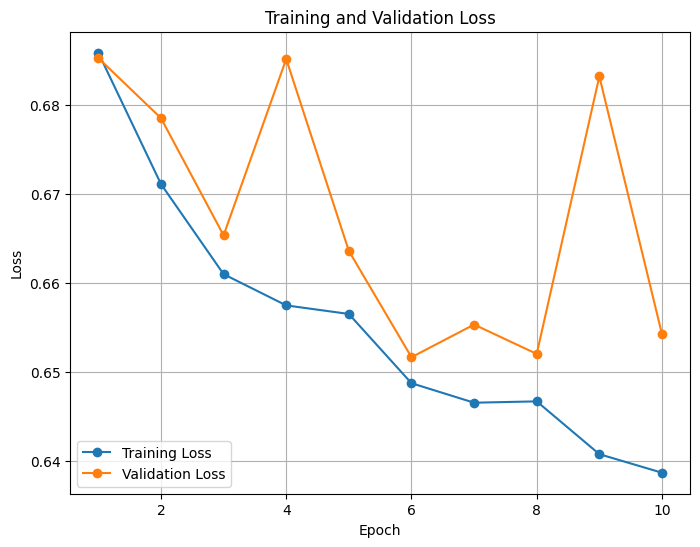

In [9]:
# Plot losses
plt.figure(figsize=(8, 6))
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, NUM_EPOCHS+1), val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')

In [10]:
# Save model
torch.save(model.state_dict(), 'cats_dogs_mlp.pth')

In [12]:
from google.colab import files
files.download('cats_dogs_mlp.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
# Inference function
def predict_image(image_path, model, transform):
    try:
        model.eval()
        model.to(device)
        image = Image.open(image_path).convert('L')
        image = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image)
            label = 'Dog' if output.item() >= 0.5 else 'Cat'
            return label, output.item()
    except UnidentifiedImageError:
        print(f"Cannot identify image: {image_path}")
        return None, None

# Example inference
sample_image_path = '/content/drive/MyDrive/dataset/validation/dogs/11961.jpg'
label, prob = predict_image(sample_image_path, model, transform)
if label is not None:
    print(f"Predicted: {label}, Probability: {prob:.4f}")

Predicted: Dog, Probability: 0.6516
